Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChains, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type Chains, with data of type 1000×2×4 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = Chain1, Chain2, Chain3, Chain4
Samples per chain = 1000
internals         = 
parameters        = sigma, mu

parameters
        Mean     SD   Naive SE  MCSE   ESS
   mu 154.6086 0.4232   0.0067 0.0072 1000
sigma   7.7648 0.2904   0.0046 0.0052 1000



Describe the draws

In [6]:
describe(chn)

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = Chain1, Chain2, Chain3, Chain4
Samples per chain = 1000
parameters        = sigma, mu

Empirical Posterior Estimates:
parameters
        Mean     SD   Naive SE  MCSE   ESS
   mu 154.6086 0.4232   0.0067 0.0072 1000
sigma   7.7648 0.2904   0.0046 0.0052 1000

Quantiles:
parameters
        2.5%    25.0%    50.0%    75.0%    97.5% 
   mu 152.997 154.3250 154.6150 154.8912 156.1810
sigma   6.812   7.5609   7.7539   7.9531   8.9175



Plot the density of posterior draws

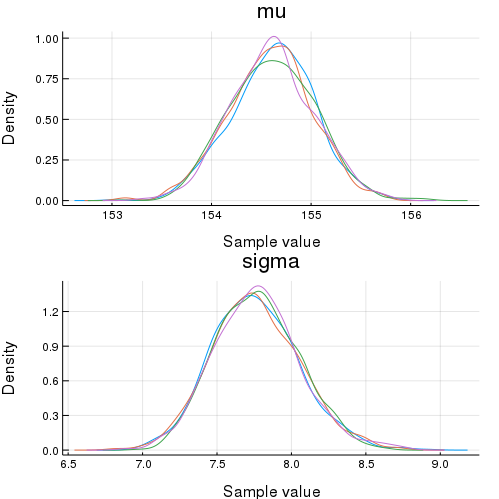

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.0863866796867939 
 0.17380572192092086

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
 1.0        0.0477028
 0.0477028  1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*